# Лабораторная работа №6 (Проведение исследований с моделями классификации)

## 1. Выбор начальных условий
### a. Набор данных для задачи классификации

Для выполнения данной работы был выбран датасет: https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset/data

Набор данных "Классификация переломов костей" может использоваться для тренировки моделей, способных классифицировать переломы костей по рентгеновским снимкам. Автоматизация процесса классификации переломов может улучшить уход за пациентами и помочь медицинским работникам принимать обоснованные решения.

In [ ]:
!pip install kaggle
!pip install opendatasets
!pip install pandas
!pip install matplotlib
!pip install torch
!pip install torchvision
!pip install seaborn
!pip install scikit-learn

Набор данных охватывает ряд классов переломов костей, таких как отрывные переломы, оскольчатые переломы, переломовывихи, переломы по типу зеленой ветки, волосяные переломы, вколоченные переломы, продольные переломы, косые переломы, патологические переломы и спиральные переломы.

In [2]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: cojihbilliko
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset


In [2]:
import os
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
data_directory = 'bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification'

Найдено классов: 10


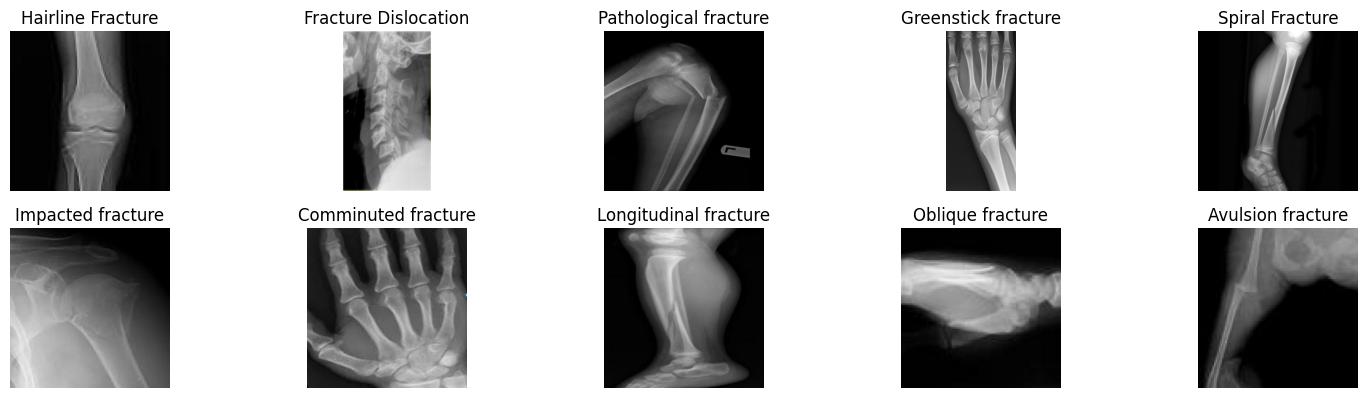

In [9]:
class_names = [class_dir for class_dir in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, class_dir))]
num_classes = len(class_names)

print("Найдено классов:", num_classes)


sample_images = []
sample_labels = []

for class_name in class_names:
    image_paths = glob.glob(os.path.join(data_directory, class_name, "Train/*.jpg"))
    if image_paths:
        selected_images = random.sample(image_paths, 1)
        sample_images.extend(selected_images)
        sample_labels.extend([class_name] * len(selected_images))


num_images_per_class = 5

plt.figure(figsize=(15, 10))
for index, (image_path, label) in enumerate(zip(sample_images, sample_labels)):
    plt.subplot(num_classes // 2, num_images_per_class, index + 1)
    image = mpimg.imread(image_path)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()


### b. Метрики качества

В качестве метрик для данной задачи будут использоваться:

$$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$
-  показывает долю правильно предсказанных изображений от общего числа
​
$$ \text{F1-score} = \frac{2 \times (precision \times recall)}{precision + recall} $$
- более детально показывает как модель справляется с классификацией, учитывая ложные срабатывания и пропуски.

## 2. Создание бейзлайна и оценка качества
### a. Обучение модели

Создадим датасет для обучения модели классификации, для этого разделим данные на тренировочную (80%) и валидационную (20%) выборки.

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

In [61]:
# Определение преобразований
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загрузка датасета из основной директории
full_dataset = datasets.ImageFolder(data_directory, transform=data_transforms)
class_names = full_dataset.classes
num_classes = len(class_names)

print("Найдено классов:", num_classes)
print(f"Всего изображений: {len(full_dataset)}")

# Разделение на тренировочную и валидационную выборки
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
print(f"Размеры выборок: {dataset_sizes}")

Найдено классов: 10
Всего изображений: 1129
Размеры выборок: {'train': 903, 'val': 226}


Определим функции тренировки модели, ее оценки по выбранным метрикам и построения матрицы ошибок.

In [26]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, data_loader, loss_function, optimizer, scheduler=None, epochs=10):
    model.train()
    for epoch in range(epochs):
        train_loss = 0

        for batch_data in data_loader:
            inputs, targets = batch_data
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            predictions = model(inputs)
            loss = loss_function(predictions, targets)

            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

            train_loss += loss.item()

        average_loss = train_loss / len(data_loader)

        print(f"Эпоха {epoch + 1}, loss: {average_loss:.5f}")

In [29]:
def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, f1

In [30]:
def plot_confusion_matrix(model, data_loader, classes):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch_data in data_loader:
            inputs, targets = batch_data
            inputs, targets = inputs.to(device), targets.to(device)

            predictions = model(inputs)

            _, predicted_labels = torch.max(predictions.data, 1)

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())

    cm = confusion_matrix(all_targets, all_predictions)

    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)

    plt.ylabel("True labels")
    plt.xlabel("Predicted labels")
    plt.title("Confusion matrix")

    plt.show()

Для задачи классификации в качестве сверточной модели будем использовать предварительно обученную сеть ResNet18.
Заменим в ней последний слой под количество классов.

In [62]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
train_model(model, train_loader, criterion, optimizer)

Эпоха 1, loss: 2.36527
Эпоха 2, loss: 1.96749
Эпоха 3, loss: 1.73579
Эпоха 4, loss: 1.52648
Эпоха 5, loss: 1.29436
Эпоха 6, loss: 1.00615
Эпоха 7, loss: 0.76134
Эпоха 8, loss: 0.66988
Эпоха 9, loss: 0.63308
Эпоха 10, loss: 0.35098


В качестве трансфомерной модели возьмем предварительно обученную модель Vision Transformer (ViT-B/16) и также заменим последний слой под количество классов.

In [67]:
model_vit = models.vit_b_16(pretrained=True)
model_vit.heads.head = nn.Linear(model_vit.heads.head.in_features, num_classes)
model_vit = model_vit.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vit.parameters(), lr=0.001)

In [68]:
train_model(model_vit, train_loader, criterion, optimizer)

Эпоха 1, loss: 2.52617
Эпоха 2, loss: 2.34554
Эпоха 3, loss: 2.34613
Эпоха 4, loss: 2.32796
Эпоха 5, loss: 2.33057
Эпоха 6, loss: 2.29938
Эпоха 7, loss: 2.30604
Эпоха 8, loss: 2.31869
Эпоха 9, loss: 2.28444
Эпоха 10, loss: 2.28955


### b. Оценка качества моделей на выбраном наборе данных
#### Оценка ResNet

In [64]:
accuracy, f1_score_val = evaluate_model(model, val_loader)

print(f"Accuracy: {accuracy:.5f}")
print(f"F1 Score: {f1_score_val:.5f}")

Accuracy: 0.35398
F1 Score: 0.32704


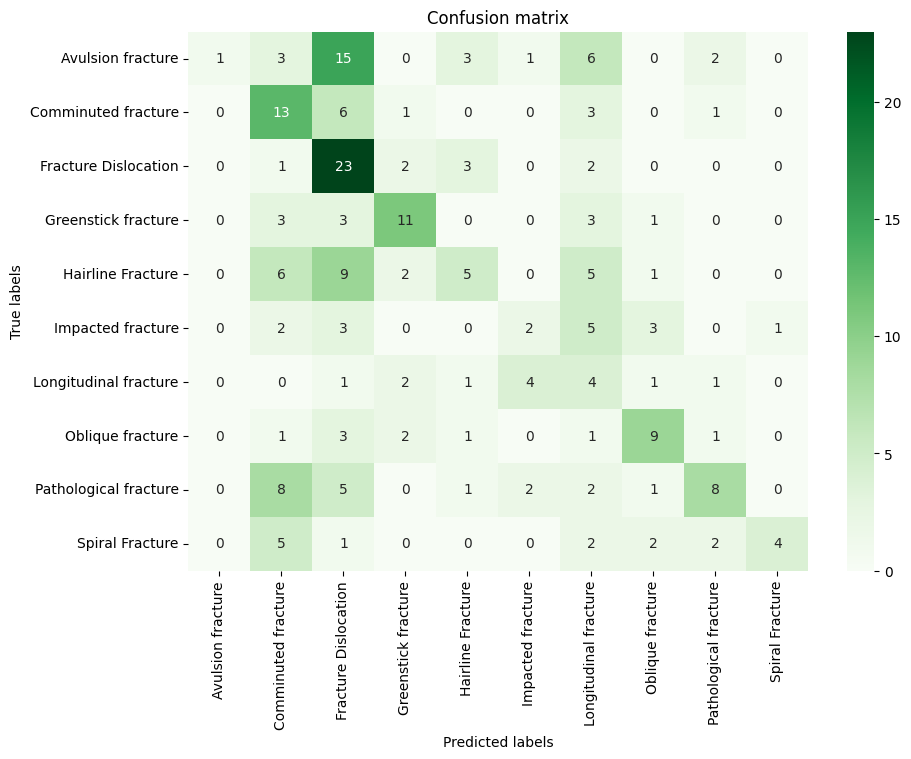

In [65]:
plot_confusion_matrix(model, val_loader, class_names)

#### Оценка ViT-B/16

In [71]:
accuracy, f1_score_val = evaluate_model(model_vit, val_loader)

print(f"Accuracy: {accuracy:.5f}")
print(f"F1 Score: {f1_score_val:.5f}")

Accuracy: 0.11947
F1 Score: 0.02601


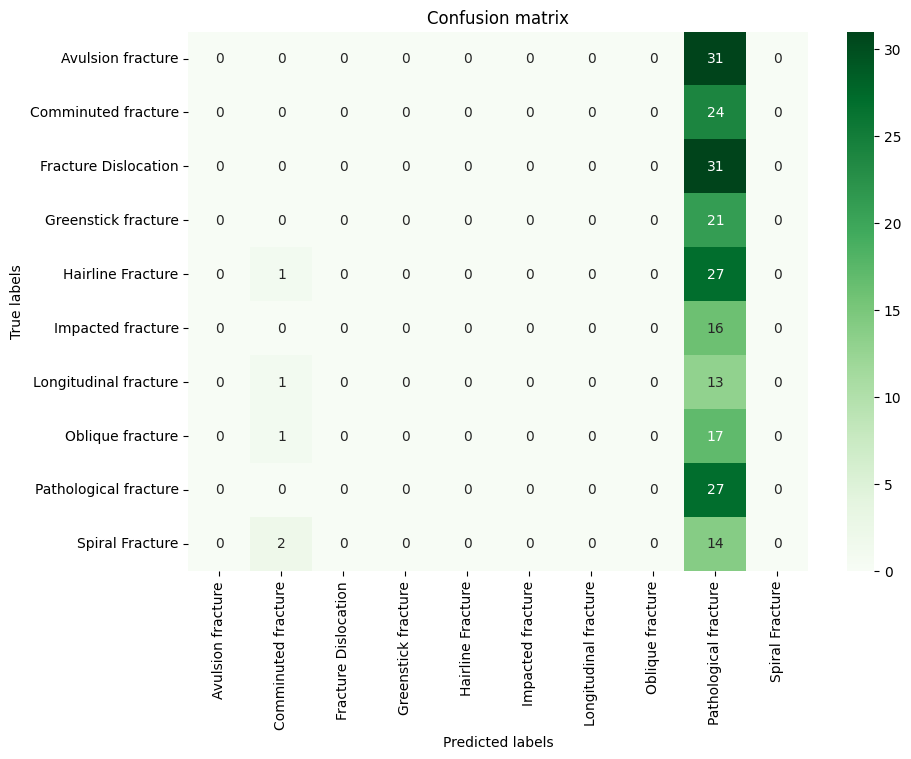

In [72]:
plot_confusion_matrix(model_vit, val_loader, class_names)

Как можно заметить, результаты неутешительные. Модель VGG обучилась луше, чем ViT, но на матрице ошибок видно, что всё равно существует много ошибочных предсказаний при валидации этой модели. ViT не обучилась совсем, во всех случаях модель предсказывала класс Pathological fractures, это можем говорить нам о том, что найденого датасета для обучения трансформерной модели недостаточно. Поэтому попробуем улучшить обучение путем применения нескольких практик.

## 3. Улучшение бейзлайна

Для улучшения показателей модели, снижения переобучения и количества ложных срабатываний могут помочь такие способы как:

* Аугментация данных

Для увеличения количества входных данных и улучшения обучения моделей можно расширить датасет путем применения горизонтального/вертикального отражения, случайных поворотов, масштабирования, изменения яркости и контраста, обрезки и наложения шумов.

* Настройка гиперпараметров

Изменение learning rate, применение более продвинутых оптимизаторов, увеличения количества эпох обучения могут также способствовать улучшению результатов.


* Fine-tuning моделей

Для трансформерной модели ViT можно попробовать заморозить начальные слои и обучать только последние.

Для увеличения данных для тренировки моделей применим аугментацию: случайные повороты, отражения, изменение яркости, контраста и масштабирования. Это позволит улучшить обобщающую способность модели. Для валидационного набора применим только базовые преобразования: изменение размера, обрезка по центру и нормализацию.

In [74]:
# Улучшенные трансформации для тренировочной выборки
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),  # Случайное горизонтальное отражение
    transforms.RandomVerticalFlip(),  # Случайное вертикальное отражение
    transforms.RandomRotation(20),  # Случайный поворот на 20 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Изменение яркости и контраста
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),  # Гауссов шум
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Применение базовых преобразований для валидации
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загрузка датасета из основной директории
full_dataset = datasets.ImageFolder(data_directory, transform=train_transforms)
class_names = full_dataset.classes
num_classes = len(class_names)

print("Найдено классов:", num_classes)
print(f"Всего изображений: {len(full_dataset)}")

# Разделение на тренировочную и валидационную выборки
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
improved_train_dataset, improved_val_dataset = random_split(full_dataset, [train_size, val_size])

improved_val_dataset.dataset.transform = val_transforms

batch_size = 32
improved_train_loader = DataLoader(improved_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
improved_val_loader = DataLoader(improved_val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

dataset_sizes = {'train': len(improved_train_dataset), 'val': len(improved_val_dataset)}
print(f"Размеры выборок: {dataset_sizes}")

Найдено классов: 10
Всего изображений: 1129
Размеры выборок: {'train': 903, 'val': 226}


Также попробуем улучшить модель, установив значение learning rate = 0.0001 и увеличив количество эпох для тренировки до 15.

In [76]:
improved_model = models.resnet18(pretrained=True)
num_ftrs = improved_model.fc.in_features
improved_model.fc = nn.Linear(num_ftrs, num_classes)
improved_model = improved_model.to(device)

criterion = nn.CrossEntropyLoss()

improved_optimizer = optim.AdamW(improved_model.parameters(), lr=0.0001)

In [78]:
train_model(improved_model, improved_train_loader, criterion, improved_optimizer, epochs=15)

Эпоха 1, loss: 2.19852
Эпоха 2, loss: 1.11066
Эпоха 3, loss: 0.53855
Эпоха 4, loss: 0.26654
Эпоха 5, loss: 0.12968
Эпоха 6, loss: 0.06675
Эпоха 7, loss: 0.04715
Эпоха 8, loss: 0.03768
Эпоха 9, loss: 0.05227
Эпоха 10, loss: 0.03276
Эпоха 11, loss: 0.01993
Эпоха 12, loss: 0.01723
Эпоха 13, loss: 0.02299
Эпоха 14, loss: 0.01869
Эпоха 15, loss: 0.01379


Для ViT также заморозим все её слои, заменяем выходной слой на новый с числом классов задачи и разрешим обучение только для него. 

In [84]:
improved_vit_model = models.vit_b_16(pretrained=True)

for param in improved_vit_model.parameters():
    param.requires_grad = False

for block in improved_vit_model.encoder.layers[-2:]:
    for param in block.parameters():
        param.requires_grad = True

improved_vit_model.heads.head = nn.Linear(improved_vit_model.heads.head.in_features, num_classes)
for param in improved_vit_model.heads.head.parameters():
    param.requires_grad = True

improved_vit_model = improved_vit_model.to(device)

criterion = nn.CrossEntropyLoss()
improved_optimizer = optim.AdamW(improved_vit_model.parameters(), lr=0.0001)

In [86]:
train_model(improved_vit_model, improved_train_loader, criterion, improved_optimizer, epochs=15)

Эпоха 1, loss: 2.04548
Эпоха 2, loss: 1.52361
Эпоха 3, loss: 1.01873
Эпоха 4, loss: 0.58616
Эпоха 5, loss: 0.31703
Эпоха 6, loss: 0.15064
Эпоха 7, loss: 0.06656
Эпоха 8, loss: 0.03514
Эпоха 9, loss: 0.02282
Эпоха 10, loss: 0.01812
Эпоха 11, loss: 0.01995
Эпоха 12, loss: 0.01097
Эпоха 13, loss: 0.00842
Эпоха 14, loss: 0.00703
Эпоха 15, loss: 0.00605


### Оценка моделей с улучшенным бейзлайном

#### Оценка ResNet

In [80]:
accuracy, f1_score_val = evaluate_model(improved_model, improved_val_loader)

print(f"Accuracy: {accuracy:.5f}")
print(f"F1 Score: {f1_score_val:.5f}")

Accuracy: 0.45133
F1 Score: 0.44432


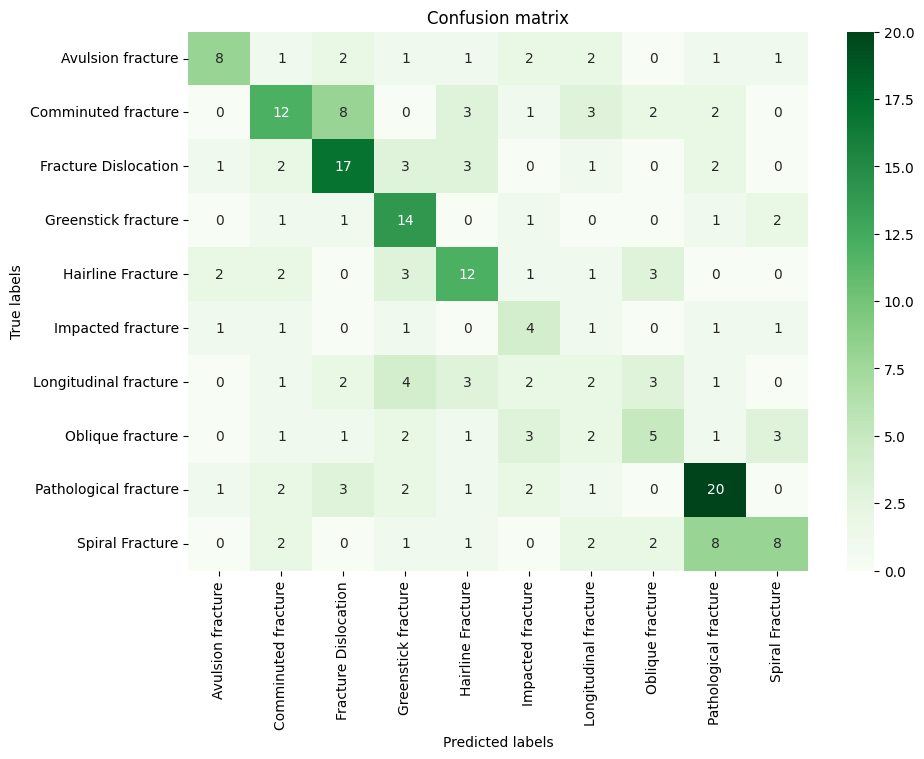

In [81]:
plot_confusion_matrix(improved_model, improved_val_loader, class_names)

#### Оценка ViT

In [87]:
accuracy, f1_score_val = evaluate_model(improved_vit_model, improved_val_loader)

print(f"Accuracy: {accuracy:.5f}")
print(f"F1 Score: {f1_score_val:.5f}")

Accuracy: 0.48230
F1 Score: 0.48115


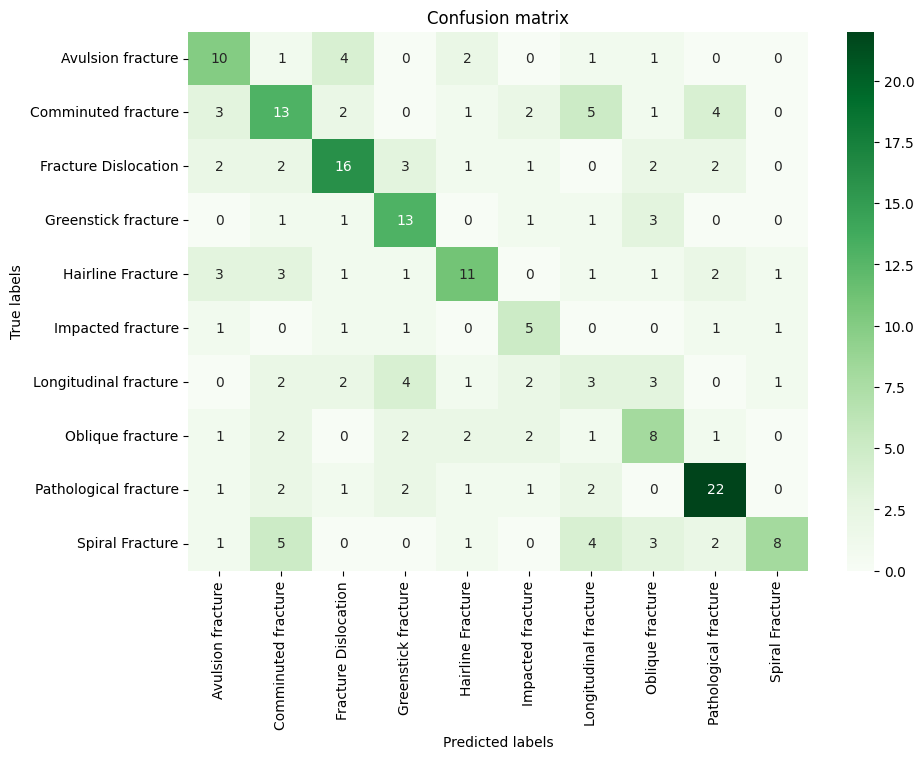

In [88]:
plot_confusion_matrix(improved_vit_model, improved_val_loader, class_names)

После подбора метрик и аугментации удалось добиться хорошего повышения значения метрик accuracy и f1-score, модели стали лучше предсказывать правильные классы. Однако все равно количество ложных предсказаний из общего числа существенно, например, Longitudinal fractures обе модели определяют достаточно плохо. Возможно еще более лучших результатов удалось бы добиться, если расширить набор данных и тренировать на большем числе эпох.

## 4. Имплементация алгоритма машинного обучения

### Сверточная модель

Определим свой собственный класс сверточной нейронной сети и проведем её обучение на исходных данных. Модель состоит из 4 сверточных блоков и двух полносвязных слоев для предсказания классов.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MyCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x1 = self.pool1(x1)

        x2 = F.relu(self.bn2(self.conv2(x1)))
        x2 = self.pool2(x2)

        x3 = F.relu(self.bn3(self.conv3(x2)))
        x3 = self.pool3(x3)

        x4 = F.relu(self.bn4(self.conv4(x3)))
        x4 = self.pool4(x4)

        x4 = x4.view(-1, 256 * 14 * 14)

        x5 = F.relu(self.fc1(x4))
        x5 = self.dropout(x5)

        out = self.fc2(x5)

        return out

In [92]:
cnn_model = MyCNN(num_classes=num_classes)
cnn_model = cnn_model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(cnn_model.parameters(), lr=0.001)

In [93]:
train_model(cnn_model, train_loader, criterion, optimizer)

Эпоха 1, loss: 11.32330
Эпоха 2, loss: 2.30698
Эпоха 3, loss: 2.27669
Эпоха 4, loss: 2.25392
Эпоха 5, loss: 2.22277
Эпоха 6, loss: 2.17743
Эпоха 7, loss: 2.17969
Эпоха 8, loss: 2.13634
Эпоха 9, loss: 2.09135
Эпоха 10, loss: 2.10865


Оценим модель по метрикам accuracy и f1-score и построим для нее матрицу ошибок.

In [94]:
accuracy, f1_score_val = evaluate_model(cnn_model, val_loader)

print(f"Accuracy: {accuracy:.5f}")
print(f"F1 Score: {f1_score_val:.5f}")

Accuracy: 0.18584
F1 Score: 0.12176


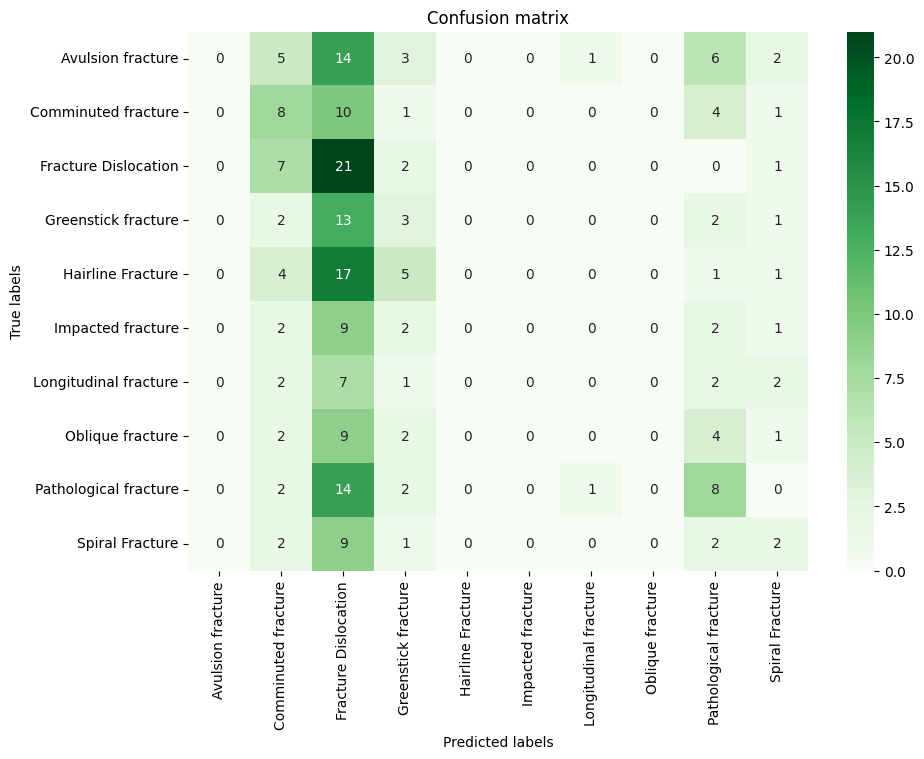

In [96]:
plot_confusion_matrix(cnn_model, val_loader, class_names)

Значения метрик и матрица ошибок показали, что обучить хорошо свою сеть не получилось. В основном всегда предсказывается класс Fractured  Dislocations, это может свидетельствовать о неравномерном распределении данных в выборке, но скорее всего это просто указывает на недостаток данных для дообучения. Посмотрим удастся ли улучшить ситуацию, используя аугментацию данных и изменение гиперпараметров.

Обучим модель на данных, которые определялись выше, с применением различных случайных преобразований. Увеличим число эпох и уменьшим learning rate.

In [103]:
improved_cnn_model = MyCNN(num_classes=num_classes)
improved_cnn_model = improved_cnn_model.to(device)

criterion = nn.CrossEntropyLoss()

improved_optimizer = optim.AdamW(improved_cnn_model.parameters(), lr=0.0001)

In [104]:
train_model(improved_cnn_model, improved_train_loader, criterion, improved_optimizer, epochs=15)

Эпоха 1, loss: 2.84484
Эпоха 2, loss: 2.17164
Эпоха 3, loss: 2.12606
Эпоха 4, loss: 2.01216
Эпоха 5, loss: 1.86085
Эпоха 6, loss: 1.75345
Эпоха 7, loss: 1.67296
Эпоха 8, loss: 1.51827
Эпоха 9, loss: 1.40278
Эпоха 10, loss: 1.29939
Эпоха 11, loss: 1.17252
Эпоха 12, loss: 1.07155
Эпоха 13, loss: 1.02579
Эпоха 14, loss: 0.90668
Эпоха 15, loss: 0.83107


In [105]:
accuracy, f1_score_val = evaluate_model(improved_cnn_model, improved_val_loader)

print(f"Accuracy: {accuracy:.5f}")
print(f"F1 Score: {f1_score_val:.5f}")

Accuracy: 0.34071
F1 Score: 0.33428


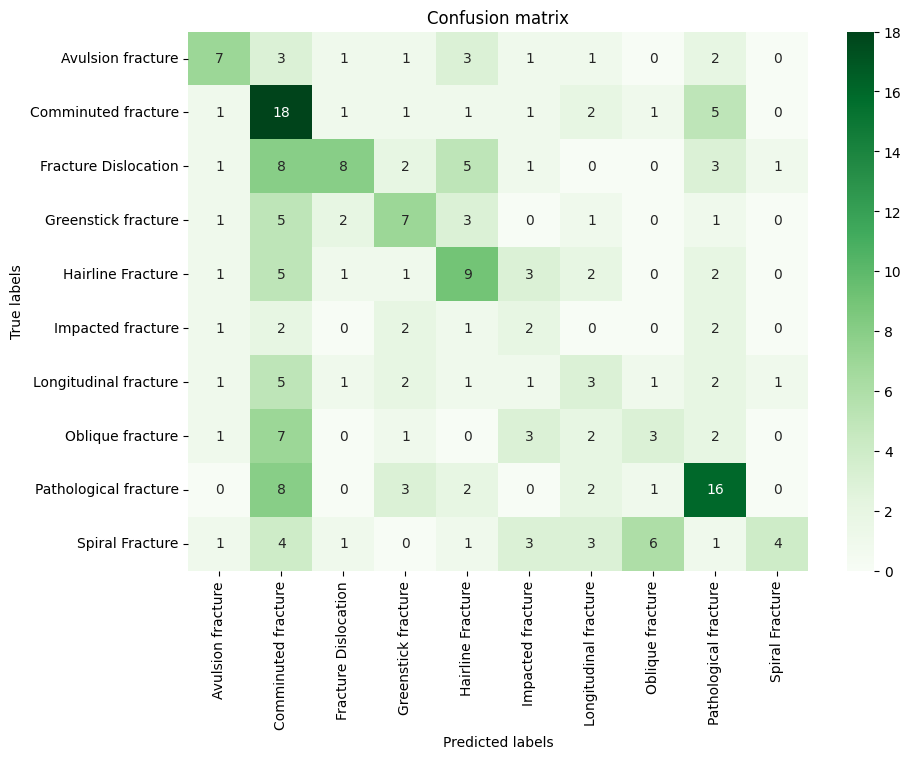

In [107]:
plot_confusion_matrix(improved_cnn_model, improved_val_loader, class_names)

Действительно, применив некоторые способы улучшения бейзлайна удалось добиться повышения метрик, однако результаты всё равно неутешительные. Модель продолжает делать много ложных предсказаний, не находя верных классов.

### Трансформерная модель

Теперь определим свой класс Vision Transformer и проведем обучение модели на исходных данных.

In [ ]:
import torch
import torch.nn as nn


class MyTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=10, dim=256, depth=6, heads=8, mlp_dim=512, dropout=0.1):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size
        self.patch_embed = nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=dropout, activation='gelu', batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_classes)
        self.batch_norm = nn.BatchNorm1d(dim)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed[:, :x.size(1)]
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.norm(x[:, 0])
        x = self.batch_norm(x)

        return self.head(x)


In [121]:
transformer_model = MyTransformer()
transformer_model = transformer_model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(transformer_model.parameters(), lr=0.001)

In [122]:
train_model(transformer_model, train_loader, criterion, optimizer)

Эпоха 1, loss: 2.47365
Эпоха 2, loss: 2.38051
Эпоха 3, loss: 2.34891
Эпоха 4, loss: 2.41507
Эпоха 5, loss: 2.39476
Эпоха 6, loss: 2.38654
Эпоха 7, loss: 2.35281
Эпоха 8, loss: 2.36615
Эпоха 9, loss: 2.35749
Эпоха 10, loss: 2.31553


In [123]:
accuracy, f1_score_val = evaluate_model(transformer_model, val_loader)

print(f"Accuracy: {accuracy:.5f}")
print(f"F1 Score: {f1_score_val:.5f}")

Accuracy: 0.13274
F1 Score: 0.03305


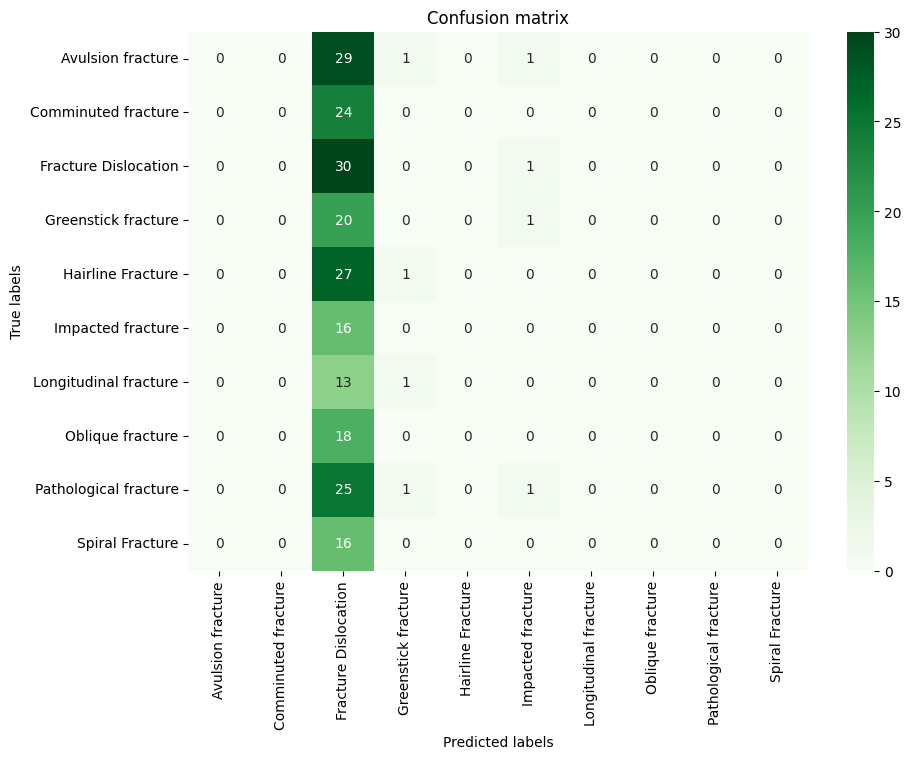

In [125]:
plot_confusion_matrix(transformer_model, val_loader, class_names)

Аналогично собственной импрементации сверточной сети на исходных данных трансформерная модель не обучилась. На валидационной выборке всегда предсказывается класс Fractured  Dislocations. Попробуем обучить свою модель на преобразованных данных и посмотрим удастся ли улучшить ситуацию при других гиперпараметрах.

Обучим модель на данных, которые определялись выше, с применением аугментации. Увеличим число эпох и уменьшим learning rate.

In [137]:
improved_transformer_model = MyTransformer()
improved_transformer_model = improved_transformer_model.to(device)

criterion = nn.CrossEntropyLoss()

improved_optimizer = optim.AdamW(improved_transformer_model.parameters(), lr=0.0001)

In [138]:
train_model(improved_transformer_model, improved_train_loader, criterion, improved_optimizer, epochs=15)

Эпоха 1, loss: 2.39632
Эпоха 2, loss: 2.32169
Эпоха 3, loss: 2.28611
Эпоха 4, loss: 2.27076
Эпоха 5, loss: 2.25946
Эпоха 6, loss: 2.21821
Эпоха 7, loss: 2.17771
Эпоха 8, loss: 2.19601
Эпоха 9, loss: 2.14669
Эпоха 10, loss: 2.09529
Эпоха 11, loss: 2.05536
Эпоха 12, loss: 1.99981
Эпоха 13, loss: 1.95703
Эпоха 14, loss: 1.90776
Эпоха 15, loss: 1.86906


In [139]:
accuracy, f1_score_val = evaluate_model(improved_transformer_model, improved_val_loader)

print(f"Accuracy: {accuracy:.5f}")
print(f"F1 Score: {f1_score_val:.5f}")

Accuracy: 0.16814
F1 Score: 0.18022


loss при обучении равномерно падал, попробуем дообучить сеть еще на 15 эпохах, так как для обучения трансформеров обычно может требоваться больше времени, возможно удастся еще повысить показатели.

In [140]:
train_model(improved_transformer_model, improved_train_loader, criterion, improved_optimizer, epochs=15)

Эпоха 1, loss: 1.79832
Эпоха 2, loss: 1.74680
Эпоха 3, loss: 1.71468
Эпоха 4, loss: 1.62172
Эпоха 5, loss: 1.59148
Эпоха 6, loss: 1.54646
Эпоха 7, loss: 1.45712
Эпоха 8, loss: 1.44101
Эпоха 9, loss: 1.35891
Эпоха 10, loss: 1.27740
Эпоха 11, loss: 1.20808
Эпоха 12, loss: 1.20578
Эпоха 13, loss: 1.11941
Эпоха 14, loss: 0.98523
Эпоха 15, loss: 0.98267


In [141]:
accuracy, f1_score_val = evaluate_model(improved_transformer_model, improved_val_loader)

print(f"Accuracy: {accuracy:.5f}")
print(f"F1 Score: {f1_score_val:.5f}")

Accuracy: 0.26549
F1 Score: 0.25612


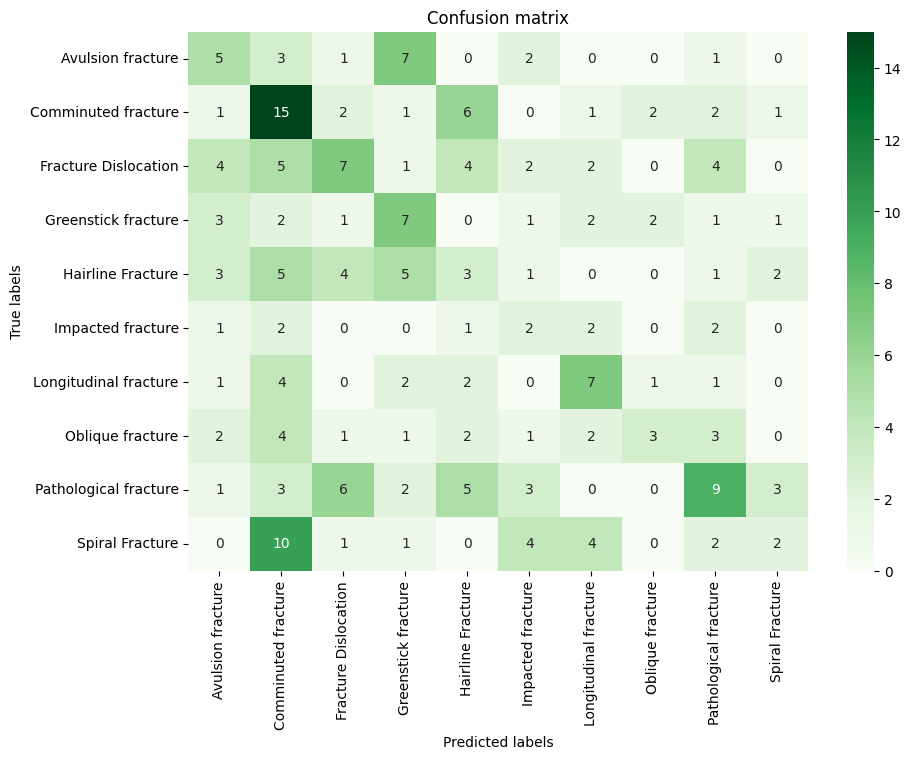

In [142]:
plot_confusion_matrix(improved_transformer_model, improved_val_loader, class_names)

Матрица потерь выглядит намного лучше изначальной, однако все равно результат недостаточно хорош, чтобы можно было применять модель для реальных задач.

## Выводы

В результате данной работы были исследованы сверточная и трансформенная архитектуры моделей для решения задачи мультиклассовой классификации изображений как и готовая их реализация из библиотеки, так своя собственная имплеметация.

К сожалению, данный набор данных оказался существенно маловат для того чтобы обучить модели находить нужные закономерности. Задача классификации переломов костей очень непроста и для того, чтобы научить модель строить нужные сложные связи. Для того чтобы делать максимально правильные предсказания по рентгеновским снимкам, необходимо более кропотливая работа и больше времени на оптимизацию и исследование. Аугментация данных показала неплохие результаты, но думаю что при еще большем наборе удалось бы добиться намного более высокой точности.

Однако даже в случае выполнения лабораторной работы с таким набором можно сделать выводы о том, что трансформерные модели в сложных задачах классификации способны показывать более высокие показатели, так как они учитывают контекст и могут улавливать более сложные взаимосвязи.